# Advanced RAG with graph path traversal

[txtai](https://github.com/neuml/txtai) is an all-in-one embeddings database for semantic search, LLM orchestration and language model workflows.

Embeddings databases are a union of vector indexes (sparse and dense), graph networks and relational databases. This enables vector search with SQL, topic modeling, retrieval augmented generation (RAG) and more.

A standard RAG process typically runs a single vector search query and returns the closest matches. Those matches are then passed into a LLM prompt and used to limit the context and help ensure more factually correct answers are generated. This works well with most simple cases. More complex use cases, require a more advanced approach.

This notebook will demonstrate how semantic graphs can be used to build a more comprehensive context for LLM generation. It will cover an example of writing a short book on English history from the fall of the Roman Empire to the Norman conquest.


# Install dependencies

Install `txtai` and all dependencies.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[graph] autoawq

# Build a knowledge base

The first step we'll take in writing this book is collecting information. We'll use the [txtai-wikipedia](https://huggingface.co/NeuML/txtai-wikipedia) database, which stores all Wikipedia article abstracts as of January 2024. This database is a great way to explore a wide variety of topics. It also has the number of page views integrated in, which enables pulling frequently viewed or popular articles on a topic.

For this example, we'll load the top 100,000 most popular articles across all of Wikipedia.

In [ ]:
from txtai import Embeddings

# Create embeddings instance with a semantic graph
embeddings = Embeddings({
  "autoid": "uuid5",
  "path": "intfloat/e5-base",
  "instructions": {
    "query": "query: ",
    "data": "passage: "
  },
  "content": True,
  "graph": {
      "approximate": False,
      "topics": {}
  }
})

# Load dataset
wikipedia = Embeddings()
wikipedia.load(provider="huggingface-hub", container="neuml/txtai-wikipedia")

query = """
SELECT id, text FROM txtai
order by percentile desc
LIMIT 100000
"""

embeddings.index(wikipedia.search(query))

# Collect articles of interest

Next, we'll build a graph query that traverses topics of interest for our book. Given that this book is about the history of England from the fall of Rome to the Norman conquest, we'll walk the graph and pull in articles relevant to that period of time.

The following builds a graph path traversal query that finds the top 20 paths between these topics.

In [ ]:
g = embeddings.graph.search("""
MATCH P=({id: "Roman Empire"})-[*1..3]->({id: "Saxons"})-[*1..3]->({id: "Vikings"})-[*1..3]->({id: "Battle of Hastings"})
RETURN P
LIMIT 20
""", graph=True)

A new feature of txtai 7.0 is the ability to return a graph of search results. This is a powerful addition as not only do we get the search results but we get how the search results relate to each other.

Now lets build a visualization showing what we've collected.

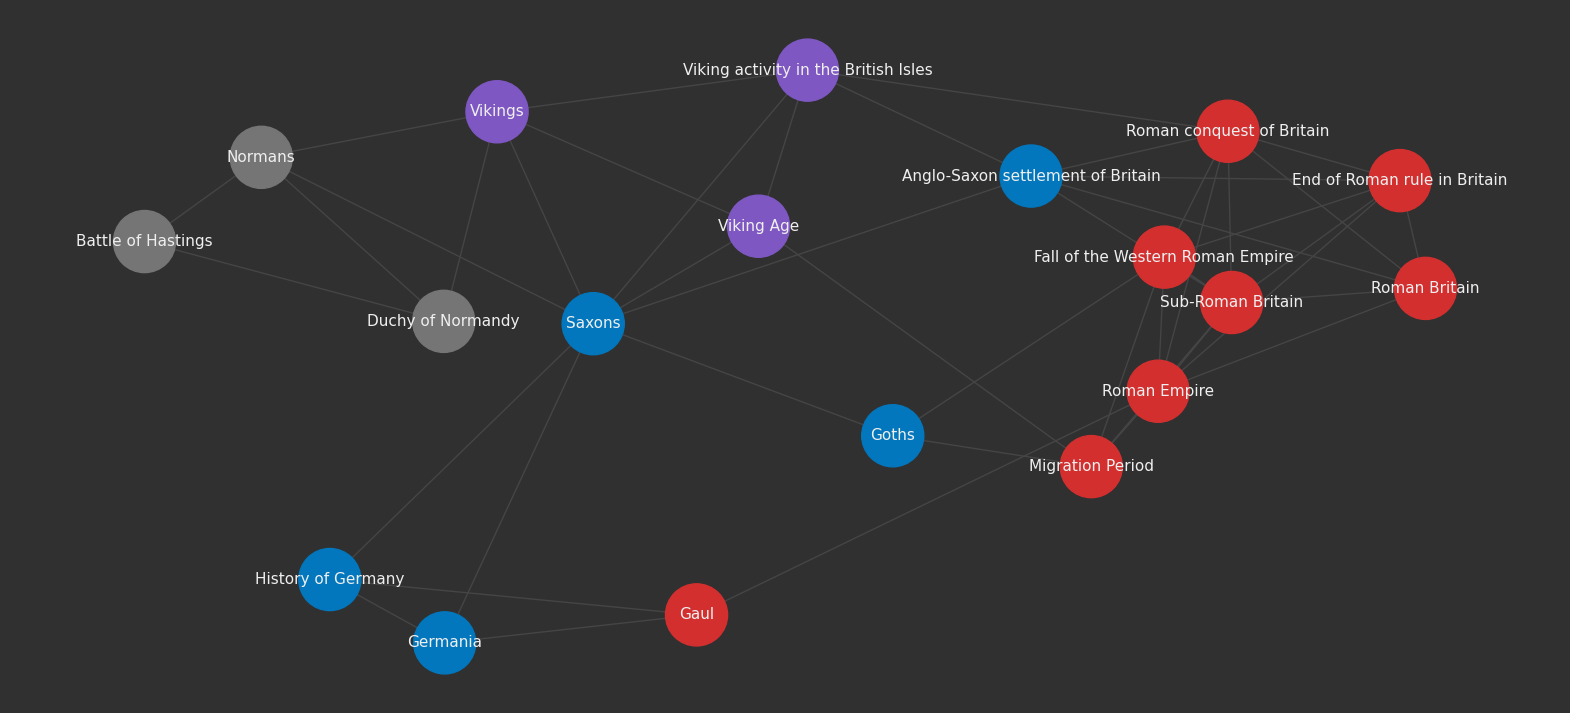

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot(graph):
    labels = {x: f"{graph.attribute(x, 'id')}" for x in graph.scan()}
    colors = ["#D32F2F", "#0277bd", "#7e57c2", "#757575"]

    results = embeddings.batchsimilarity(labels.values(), ["Roman Empire", "Germanic barbarians", "Vikings", "Normans invade"])
    colors = [colors[x[0][0]] for x in results]

    options = {
        "node_size": 2000,
        "node_color": colors,
        "edge_color": "#454545",
        "font_color": "#efefef",
        "font_size": 11,
        "alpha": 1.0,
    }

    fig, ax = plt.subplots(figsize=(20, 9))
    pos = nx.spring_layout(graph.backend, seed=0, k=0.9, iterations=50)
    nx.draw_networkx(graph.backend, pos=pos, labels=labels, **options)
    ax.set_facecolor("#303030")
    ax.axis("off")
    fig.set_facecolor("#303030")

    plt.show()

plot(g)

Each one of the nodes in the graph above is a Wikipedia article abstract. For example, the `Saxons` entry is the Wikipedia abstract text for the Saxons article. The `Roman Empire` gives a summary of the Roman Empire and so forth.

Clearly, we have aggregated an extremely relevant set of articles with the graph path query. This is a solid knowledge base related to the fall of Rome, Saxons, Vikings and Norman conquest.

# Write a short history book

Now that we have our collection of articles, let's write our book!

We'll load a LLM and build a prompt that uses the graph network of articles and a user input command to build the book.

In [ ]:
from txtai import LLM

llm = LLM("TheBloke/Mistral-7B-OpenOrca-AWQ")

In [ ]:
def rag(question, text):
    prompt = f"""<|im_start|>system
    You are a friendly assistant. You answer questions from users.<|im_end|>
    <|im_start|>user
    Answer the following question using only the context below. Only include information specifically discussed.

    question: {question}
    context: {text} <|im_end|>
    <|im_start|>assistant
    """

    return llm(prompt, maxlength=4096)

context = "\n".join(g.attribute(node, "text") for node in list(g.scan()))

print(rag("Write a book covering the end of Roman Britain, Saxons, Vikings and Norman conquest of England", context))


Title: "The Fall and Rise of Britain: From Roman Rule to the Norman Conquest"

Chapter 1: The Fall of the Western Roman Empire
The Western Roman Empire fell due to a combination of factors, including the effectiveness and numbers of the army, the health and numbers of the Roman population, the strength of the economy, the competence of the emperors, internal struggles for power, religious changes, and the efficiency of the civil administration. Barbarian invasions and climatic changes also played a significant role in the collapse.

Chapter 2: Roman Britain
Roman Britain was the territory that became the Roman province of Britannia after the Roman conquest of Britain, consisting of a large part of the island of Great Britain. The occupation lasted from AD 43 to AD 410.

Chapter 3: The End of Roman Rule in Britain
Roman rule in Britain ended in different parts of the country at different times and under different circumstances. The recall of Roman troops to Gaul by Constantine III in 40

_It's important to note that txtai has multiple ways to run LLM inference. In the past, prior to "Chat Templates", it was expected that the submitted text had all the required chat tokens embedded. The same prompt above can also be written with chat messages. This is especially important when working with LLM APIs (i.e. OpenAI, Claude, Bedrock etc)._

```python
llm([
    {"role": "system": "You are a friendly assistant. You answer questions from users."}
    {"role": "user", "content": f"""
        Answer the following question using only the context below. Only include information specifically discussed.

        question: {question}
        context: {text} 
    """}
])
```

_See the [LLM pipeline documentation](https://neuml.github.io/txtai/pipeline/text/llm/) for more information._

# Wrapping up

Just that like that, we have a short book of history covering the early medieval period in England! 📖🛡️🗡️🏴󠁧󠁢󠁥󠁮󠁧󠁿

It's quite amazing when we think about it. This notebook took the full set of Wikipedia articles, walked a graph to pull articles related to a series of topics and used that to build a short book!

It's also a stark contrast to a standard RAG process. There is no way we'd be able to get the breadth of knowledge with a simple vector search query. The graph path traversal is the key advancement here. This is just the beginning, more to come!